In [1]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pennylane as qml
import matplotlib.pyplot as plt


In [15]:
# Directory containing the XYZ files
xyz_dir = "QM9/dsgdb9nsd.xyz"

def parse_xyz(file_path):

    """
    Parses an XYZ file to extract atomic types, 3D coordinates, and partial atomic charges.
    
    Args:
    - file_path (str): Path to the XYZ file.

    Returns:
    - atom_types (list of str): A list of atomic symbols (e.g., ['C', 'H', 'O']).
    - coordinates (np.ndarray): A NumPy array of shape (num_atoms, 3) containing the (x, y, z) coordinates of each atom.
    - charges (np.ndarray): A NumPy array containing the partial atomic charges for each atom.
    
    The XYZ file contains:
    - Number of atoms on the first line.
    - Metadata on the second line (skipped here).
    - Atom information from the third line onward, including the atom type, (x, y, z) coordinates, and atomic charge.
    """

    with open(file_path, 'r') as f:
        lines = f.readlines()
        
        # Step 1: Get the number of atoms
        num_atoms = int(lines[0].strip())
        
        # Step 2: Extract atomic types, coordinates, and charges
        atom_types = []
        coordinates = []
        charges = []

        for i in range(2, 2 + num_atoms):
            parts = lines[i].strip().split()
            atom_types.append(parts[0])  # Atom symbol (C, H, O, etc.)
            coords = [float(part.replace('*^', 'e')) for part in parts[1:4]]  # Fix coordinates
            charge = float(parts[4].replace('*^', 'e'))  # Fix charges
            coordinates.append(coords)
            charges.append(charge)
        
        return atom_types, np.array(coordinates), np.array(charges)

In [16]:
def compute_features(atom_types, coordinates):

    """
    Computes a feature vector for a molecule based on its atom types and atomic coordinates.
    
    Args:
    - atom_types (list of str): A list of atomic symbols (e.g., ['C', 'H', 'O']).
    - coordinates (np.ndarray): A NumPy array of shape (num_atoms, 3) containing the (x, y, z) coordinates of each atom.
    
    Returns:
    - np.ndarray: A 1D NumPy array containing:
        [number of C atoms, number of H atoms, number of O atoms, mean pairwise distance, max pairwise distance]
    
    Feature breakdown:
    - Atom type counts (C, H, O)
    - Mean distance between all pairs of atoms
    - Maximum distance between any two atoms
    """

    # Step 1: Count the number of atoms of each type (C, H, O)
    atom_counts = Counter(atom_types)
    num_c = atom_counts.get('C', 0)
    num_h = atom_counts.get('H', 0)
    num_o = atom_counts.get('O', 0)
    
    # Step 2: Compute pairwise distances between all atoms
    pairwise_distances = squareform(pdist(coordinates))
    
    # Step 3: Compute the mean and max pairwise distances
    mean_distance = np.mean(pairwise_distances)
    max_distance = np.max(pairwise_distances)
    
    # Step 4: Return the feature vector (you can extend this as needed)
    return np.array([num_c, num_h, num_o, mean_distance, max_distance])


In [25]:
def calculate_dipole_moment(atom_types, coordinates, charges):
    """
    Calculates the molecular dipole moment in Debye based on atomic positions and charges.
    
    Args:
    - atom_types (list of str): A list of atomic symbols (e.g., ['C', 'H', 'O']).
    - coordinates (np.ndarray): A NumPy array of shape (num_atoms, 3) containing the (x, y, z) atomic coordinates in angstroms.
    - charges (np.ndarray): A NumPy array containing the partial charges of the atoms.
    
    Returns:
    - float: The magnitude of the dipole moment in Debye.
    
    Steps:
    1. Convert coordinates from angstroms to bohr.
    2. Calculate the dipole moment components by summing (charge × position) for each axis.
    3. Compute the magnitude of the dipole moment in atomic units.
    4. Convert the dipole moment from atomic units to Debye (1 e·bohr = 2.541746 Debye).
    """
    
    # Step 1: Conversion factor from angstroms to bohr (1 angstrom = 1.8897259886 bohr)
    angstrom_to_bohr = 1.8897259886  
    coordinates_bohr = coordinates * angstrom_to_bohr  # Convert coordinates to bohr units

    # Step 2: Calculate the dipole moment components (charge × position) along each axis
    # This results in a vector representing the dipole moment in atomic units
    dipole_components = np.sum(charges[:, np.newaxis] * coordinates_bohr, axis=0)  

    # Step 3: Compute the magnitude of the dipole moment in atomic units (e·bohr)
    dipole_magnitude_au = np.linalg.norm(dipole_components)  # Magnitude of the vector

    # Step 4: Convert the dipole moment from atomic units to Debye (1 e·bohr ≈ 2.541746 Debye)
    dipole_magnitude_debye = dipole_magnitude_au * 2.541746  

    return dipole_magnitude_debye  # Return the dipole moment in Debye


In [26]:
# Step 1: Initialize an empty list to store data for each molecule
molecule_data = []

# Step 2: Loop through all XYZ files in the specified directory
for file_name in os.listdir(xyz_dir):
    if file_name.endswith(".xyz"):  # Process only .xyz files
        file_path = os.path.join(xyz_dir, file_name)  # Get the full file path

        # Step 3: Parse the XYZ file to extract atomic types, coordinates, and charges
        atom_types, coordinates, charges = parse_xyz(file_path)

        # Step 4: Compute molecular features (e.g., atom counts, distances)
        features = compute_features(atom_types, coordinates)

        # Step 5: Dynamically calculate the dipole moment using the parsed data
        target_property = calculate_dipole_moment(atom_types, coordinates, charges)

        # Step 6: Store the parsed and calculated data in a dictionary
        molecule_data.append({
            "file_name": file_name,  # Name of the XYZ file
            "features": features,  # Feature vector for the molecule
            "target_property": target_property  # Dipole moment in Debye
        })

# Step 7: Convert the list of dictionaries into a pandas DataFrame for analysis
df = pd.DataFrame(molecule_data)

# Step 8: Display the first few rows of the DataFrame to verify the data
print(df.head())


              file_name                                           features  \
0  dsgdb9nsd_000001.xyz  [1.0, 4.0, 0.0, 1.2053341170795622, 1.78315766...   
1  dsgdb9nsd_000002.xyz  [0.0, 3.0, 0.0, 0.9884404226522757, 1.61870992...   
2  dsgdb9nsd_000003.xyz  [0.0, 2.0, 1.0, 0.7639047756163965, 1.51335786...   
3  dsgdb9nsd_000004.xyz      [2.0, 2.0, 0.0, 1.396113812525, 3.3232771722]   
4  dsgdb9nsd_000005.xyz  [1.0, 1.0, 0.0, 0.9859315432225048, 2.21834597...   

   target_property  
0         0.000029  
1         1.364329  
2         1.683089  
3         0.000000  
4         2.262593  


In [30]:
# Specify the path to the XYZ file to test dipole moment calculation
file_path = "QM9/dsgdb9nsd.xyz/dsgdb9nsd_000002.xyz"  # Example: Ammonia (NH3)

# Step 1: Open and read the file
with open(file_path, 'r') as f:
    lines = f.readlines()  # Read all lines of the XYZ file
    
    # Step 2: Extract the number of atoms from the first line
    num_atoms = int(lines[0].strip())

    # Step 3: Parse the XYZ file to extract atom types, coordinates, and charges
    atom_types, coordinates, charges = parse_xyz(file_path)

    # Step 4: Calculate the dipole moment using the parsed data
    dipole_moment = calculate_dipole_moment(atom_types, coordinates, charges)

    # Step 5: Display the result
    print(f"Corrected dipole moment for NH3 (Debye): {dipole_moment:.6f}")


Corrected dipole moment for NH3 (Debye): 1.364329


In [29]:
# Specify the path to the XYZ file to inspect atom types and charges
file_path = "QM9/dsgdb9nsd.xyz/dsgdb9nsd_000002.xyz"  # Example: Ammonia (NH3)

# Step 1: Open and read the XYZ file
with open(file_path, 'r') as f:
    lines = f.readlines()  # Read all lines of the file
    
    # Step 2: Extract the number of atoms from the first line
    num_atoms = int(lines[0].strip())

    # Step 3: Parse the XYZ file to extract atom types, coordinates, and charges
    atom_types, coordinates, charges = parse_xyz(file_path)

    # Step 4: Display the atom types along with their corresponding charges
    print("Atom Types and Charges:")
    for atom, charge in zip(atom_types, charges):
        print(f"{atom}: {charge:.6f}")  # Display the charge with six decimal precision


Atom Types and Charges:
N: -0.707143
H: 0.235712
H: 0.235712
H: 0.23572


In [31]:
# Step 1: Count the number of NaN values in the target property column
nan_count = df['target_property'].isna().sum()  # Number of NaNs in the target property

# Step 2: Count the total number of entries in the DataFrame
total_count = len(df)  # Total number of molecules

# Step 3: Print the number and percentage of NaN values
print(f"Number of NaN values in target property: {nan_count}")
print(f"Percentage of NaNs: {(nan_count / total_count) * 100:.2f}%")


Number of NaN values in target property: 0
Percentage of NaNs: 0.00%


In [32]:
# Step 1: Convert the 'features' column into a NumPy feature matrix
# Each row corresponds to the features of a molecule, and each column to a specific feature
X = np.array([np.array(f) for f in df['features']])  # Shape: (num_molecules, num_features)

# Step 2: Extract the target values (dipole moment in Debye)
y = df['target_property'].values  # Shape: (num_molecules,)

# Step 3: Split the dataset into training (80%) and test (20%) sets
# random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize scalers to normalize the features and target property
scaler_X = StandardScaler()  # Feature scaling to zero mean and unit variance
scaler_y = StandardScaler()  # Target scaling

# Step 5: Normalize the training and test feature sets
X_train = scaler_X.fit_transform(X_train)  # Fit and transform the training features
X_test = scaler_X.transform(X_test)  # Apply the same transformation to the test set

# Step 6: Normalize the target property (dipole moment)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()  # Fit and transform training targets
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()  # Transform test targets using the same scaling

# Step 7: Display the shapes of the training and test sets for verification
print("Training set shape:", X_train.shape)  # Example: (8000, 5) for 8000 molecules with 5 features
print("Test set shape:", X_test.shape)  # Example: (2000, 5)


Training set shape: (107108, 5)
Test set shape: (26777, 5)


More intricate circuit, with added layer of RY, RZ gates, and CNOT gates to improve the circuit’s expressiveness. also updated the weights.

In [35]:
# Number of qubits = number of features
n_qubits = X_train.shape[1]
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnn_circuit(inputs, weights):
    # =========================
    # Step 1: Input Encoding
    # =========================
    # Encode the classical data using a combination of RX, RY, and RZ rotations
    for i in range(n_qubits):
        qml.RX(inputs[i], wires=i)
        qml.RY(inputs[i] * 1.2, wires=i)  # Add scaling for diversity
        qml.RZ(inputs[i] * 0.8, wires=i)

    # =========================
    # Step 2: Layered Circuit
    # =========================
    # Add multiple layers of parameterized rotations and entanglement
    num_layers = 5  # You can experiment with more layers if your setup allows
    for layer in range(num_layers):
        # Parameterized rotations (diversify using RX, RY, RZ)
        for i in range(n_qubits):
            qml.RX(weights[layer * 3 * n_qubits + i], wires=i)
            qml.RY(weights[layer * 3 * n_qubits + n_qubits + i], wires=i)
            qml.RZ(weights[layer * 3 * n_qubits + 2 * n_qubits + i], wires=i)
        
        # Entanglement using both CNOT and CZ gates
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])  # Local entanglement
        for i in range(n_qubits):
            target = (i + 2) % n_qubits  # Entangle distant qubits
            qml.CZ(wires=[i, target])

    # ===============================
    # Step 3: Multi-Qubit Measurement
    # ===============================
    # Return the combined expectation values of multiple qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [39]:
def huber_loss(predictions, y, delta=1.0):
    """
    Calculates the Huber loss for dipole moment predictions with multi-qubit measurements.
    
    Args:
    - predictions (np.ndarray): Predicted dipole moments from multi-qubit outputs, shape (batch_size, n_qubits).
    - y (np.ndarray): Actual dipole moments, shape (batch_size,).
    - delta (float): The threshold for switching between MSE and MAE.
    
    Returns:
    - float: The average Huber loss.
    """
    # Step 1: Combine the multi-qubit predictions (mean or weighted combination)
    combined_predictions = np.mean(predictions, axis=1)  # Shape (batch_size,)
    
    # Step 2: Compute residuals
    residuals = np.abs(combined_predictions - y)
    
    # Step 3: Apply the Huber loss formula
    loss = np.where(
        residuals <= delta,
        0.5 * residuals**2,
        delta * residuals - 0.5 * delta**2
    )
    
    return np.mean(loss)


Epoch 1/20: Average Training Loss = 0.3410, Time = 1321.39 s
New best loss: 0.3410 at epoch 1. Saving model.
Epoch 2/20: Average Training Loss = 0.3365, Time = 1317.01 s
New best loss: 0.3365 at epoch 2. Saving model.
Epoch 3/20: Average Training Loss = 0.3354, Time = 1310.47 s
New best loss: 0.3354 at epoch 3. Saving model.
Epoch 4/20: Average Training Loss = 0.3343, Time = 1313.73 s
New best loss: 0.3343 at epoch 4. Saving model.
Epoch 5/20: Average Training Loss = 0.3341, Time = 1343.67 s
New best loss: 0.3341 at epoch 5. Saving model.
Epoch 6/20: Average Training Loss = 0.3340, Time = 1334.22 s
New best loss: 0.3340 at epoch 6. Saving model.
Epoch 7/20: Average Training Loss = 0.3339, Time = 1327.60 s
New best loss: 0.3339 at epoch 7. Saving model.
Epoch 8/20: Average Training Loss = 0.3339, Time = 1346.01 s
New best loss: 0.3339 at epoch 8. Saving model.
Epoch 9/20: Average Training Loss = 0.3339, Time = 1373.50 s
Epoch 10/20: Average Training Loss = 0.3338, Time = 1383.34 s
New b

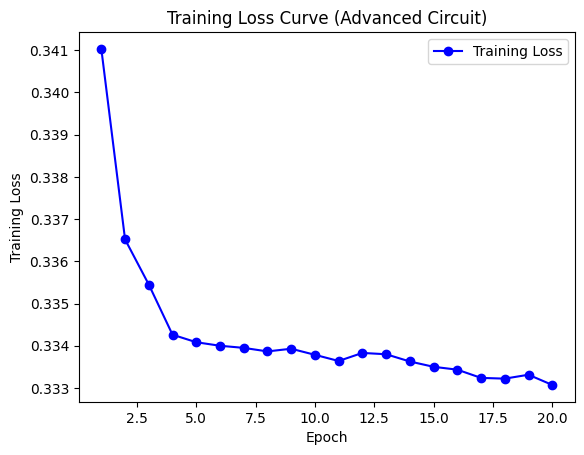

In [42]:
from pennylane import numpy as np
from sklearn.utils import shuffle
import time
import pickle

# Initialize weights and optimizer
weights = np.random.randn(6 * 3 * n_qubits)  # Initial weights based on circuit size (6 layers, 3 gates per qubit)
opt = qml.AdamOptimizer(stepsize=0.01)  # Adam optimizer with initial learning rate

# Training settings
batch_size = 50  # Number of samples per mini-batch
n_epochs = 20  # Number of full passes through the dataset
decay_rate = 0.1  # Rate for decaying the learning rate
convergence_limit = 4  # Stop training after 4 consecutive epochs with no improvement
best_loss = float('inf')  # Initialize best loss as infinity
epochs_without_improvement = 0  # Counter to track early stopping
best_weights = None  # Store the best weights

loss_history = []  # To store loss at each epoch for visualization

# ===========================
# Main Training Loop
# ===========================
for epoch in range(n_epochs):
    start_time = time.time()  # Start the timer for the epoch

    # Step 1: Adjust learning rate dynamically based on the epoch
    current_stepsize = 0.01 / (1 + decay_rate * epoch)
    opt.stepsize = current_stepsize

    # Step 2: Shuffle the training data and create mini-batches
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)  # Randomly shuffle data for each epoch
    X_train_batches = [X_train_shuffled[i:i + batch_size] for i in range(0, len(X_train_shuffled), batch_size)]
    y_train_batches = [y_train_shuffled[i:i + batch_size] for i in range(0, len(y_train_shuffled), batch_size)]

    epoch_losses = []  # To store the losses for each mini-batch

    # ===========================
    # Mini-Batch Training
    # ===========================
    for X_batch, y_batch in zip(X_train_batches, y_train_batches):
        # Objective function that computes the Huber loss for a mini-batch
        def objective_fn(w):
            # Get predictions from the quantum circuit for the current mini-batch
            predictions = np.array([qnn_circuit(x, w) for x in X_batch])
            return huber_loss(predictions, y_batch)  # Compute Huber loss
        
        # Step 3: Update the weights using the optimizer
        weights = opt.step(objective_fn, weights)
        
        # Step 4: Calculate the batch loss after updating the weights
        batch_loss = objective_fn(weights)
        epoch_losses.append(batch_loss)

    # Step 5: Compute the average loss for this epoch and store it
    avg_epoch_loss = np.mean(epoch_losses)
    loss_history.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}/{n_epochs}: Average Training Loss = {avg_epoch_loss:.4f}, "
          f"Time = {time.time() - start_time:.2f} s")

    # Step 6: Check for improvement and save the best model
    if avg_epoch_loss < best_loss:
        print(f"New best loss: {avg_epoch_loss:.4f} at epoch {epoch + 1}. Saving model.")
        best_loss = avg_epoch_loss
        best_weights = weights.copy()  # Save a copy of the best weights
        epochs_without_improvement = 0  # Reset the counter
    else:
        epochs_without_improvement += 1  # Increment the counter if no improvement

    # Step 7: Early stopping if no improvement for `convergence_limit` epochs
    if epochs_without_improvement >= convergence_limit:
        print(f"Stopping early at epoch {epoch + 1}. No improvement for {convergence_limit} consecutive epochs.")
        break

# Step 8: Save the best model weights to a file
with open("best_qnn_dipole_weights.pkl", "wb") as f:
    pickle.dump(best_weights, f)
    print("Best model weights saved to 'best_qnn_dipole_weights.pkl'.")

# Step 9: Plot the training loss curve for visualization
plt.plot(range(1, len(loss_history) + 1), loss_history, 'b-o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve (Advanced Circuit)')
plt.legend()
plt.show()


In [43]:

from sklearn.metrics import mean_absolute_error

# Load the best model weights
with open("best_qnn_dipole_weights.pkl", "rb") as f:
    best_weights = pickle.load(f)

# Define the testing function
def test_qnn(X_test, y_test, delta=1.0):
    """
    Tests the trained QNN on the test set and evaluates performance metrics.
    
    Args:
    - X_test (np.ndarray): Test feature data.
    - y_test (np.ndarray): Actual dipole moments for the test set.
    - delta (float): Threshold for switching between MSE and MAE in Huber loss.

    Returns:
    - dict: Dictionary containing Huber loss, MSE, MAE, and R² score.
    """
    # Step 1: Make predictions using the QNN circuit
    predictions = np.array([qnn_circuit(x, best_weights) for x in X_test])  # Shape (batch_size, n_qubits)
    combined_predictions = np.mean(predictions, axis=1)  # Combine multi-qubit outputs (if any)

    # Step 2: Calculate evaluation metrics
    huber = huber_loss(predictions, y_test, delta=delta)  # Huber loss
    mse = mean_squared_error(y_test, combined_predictions)  # MSE
    mae = mean_absolute_error(y_test, combined_predictions)  # MAE
    r2 = r2_score(y_test, combined_predictions)  # R² score

    # Return the evaluation results
    return {
        "Huber Loss": huber,
        "MSE": mse,
        "MAE": mae,
        "R² Score": r2
    }

# Test the QNN and print results
results = test_qnn(X_test, y_test, delta=1.0)
print("Evaluation Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")


Evaluation Results:
Huber Loss: 0.3318
MSE: 0.8838
MAE: 0.6806
R² Score: 0.1213
